# Colour - Checker Detection - Examples: Segmentation

This notebook showcases segmentation retated colour checker detection examples.

<div class="alert alert-info">
The original *.CR2 files were processed with *dcraw* as follows: <code>dcraw -T -g 2.4 12.92 *.CR2</code> and then resized and converted to *.png.
</div>


In [6]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import colour

from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    SETTINGS_SEGMENTATION_COLORCHECKER_CLASSIC,
    colour_checkers_coordinates_segmentation,
    detect_colour_checkers_segmentation)
from colour_checker_detection.detection.segmentation import (
    adjust_image)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC    *
*   v.1933 64 bit (AMD64)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.2                                                        *
*       colour-checker-detection : 0.1.4                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.22.0                                                      *
*       matplotlib : 3.6.0                                                    *
*       networkx : 2.8.6                

## Data

c:\Users\s830s\AppData\Local\Programs\Python\Python310\lib\site-packages\colour\utilities\verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


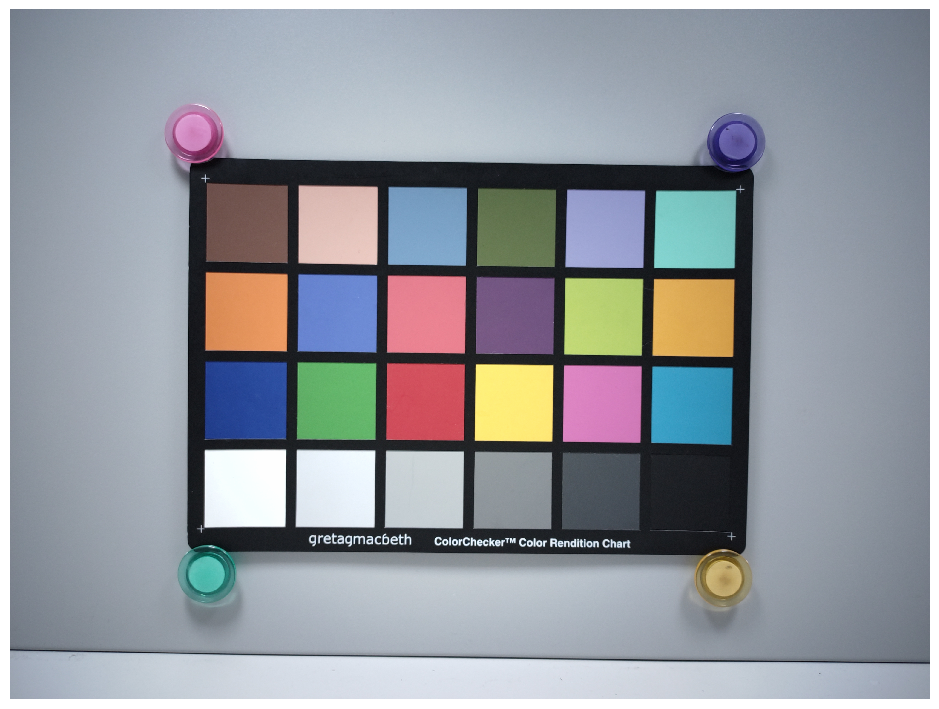

In [7]:
COLOUR_CHECKER_IMAGE_PATHS = ["1.jpg"]

COLOUR_CHECKER_IMAGES = [
    colour.cctf_decoding(colour.io.read_image(path))
    for path in COLOUR_CHECKER_IMAGE_PATHS
]

for image in COLOUR_CHECKER_IMAGES:
    colour.plotting.plot_image(colour.cctf_encoding(image))

## Detection

In [8]:
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    for colour_checker_swatches_data in detect_colour_checkers_segmentation(
        image, additional_data=True):
        swatch_colours, colour_checker_image, swatch_masks = (
            colour_checker_swatches_data.values)
        SWATCHES.append(swatch_colours)
        
        # Using the additional data to plot the colour checker and masks.
        masks_i = np.zeros(colour_checker_image.shape)
        for i, mask in enumerate(swatch_masks):
            masks_i[mask[0]:mask[1], mask[2]:mask[3], ...] = 1
        colour.plotting.plot_image(
            colour.cctf_encoding(
                np.clip(colour_checker_image + masks_i * 0.25, 0, 1)));

## Colour Fitting

In [9]:
D65 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
REFERENCE_COLOUR_CHECKER = colour.CCS_COLOURCHECKERS[
    'ColorChecker24 - After November 2014']

# NOTE: The reference swatches values as produced by the "colour.XYZ_to_RGB"
# definition are linear by default.
# See https://github.com/colour-science/colour-checker-detection/discussions/59
# for more information.
REFERENCE_SWATCHES = colour.XYZ_to_RGB(
        colour.xyY_to_XYZ(list(REFERENCE_COLOUR_CHECKER.data.values())),
        REFERENCE_COLOUR_CHECKER.illuminant, D65,
        colour.RGB_COLOURSPACES['sRGB'].matrix_XYZ_to_RGB)

for i, swatches in enumerate(SWATCHES):
    swatches_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches, D65, D65, colour.RGB_COLOURSPACES['sRGB'].matrix_RGB_to_XYZ))

    colour_checker = colour.characterisation.ColourChecker(
        os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_xyY)),
        D65)
    
    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker])
    
    swatches_f = colour.colour_correction(swatches, swatches, REFERENCE_SWATCHES)
    swatches_f_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(
        swatches_f, D65, D65, colour.RGB_COLOURSPACES['sRGB'].matrix_RGB_to_XYZ))
    colour_checker = colour.characterisation.ColourChecker(
        '{0} - CC'.format(os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i])),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_f_xyY)),
        D65)
    
    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker])

    colour.plotting.plot_image(colour.cctf_encoding(
        colour.colour_correction(
            COLOUR_CHECKER_IMAGES[i], swatches, REFERENCE_SWATCHES)));

## Additional Data Plotting

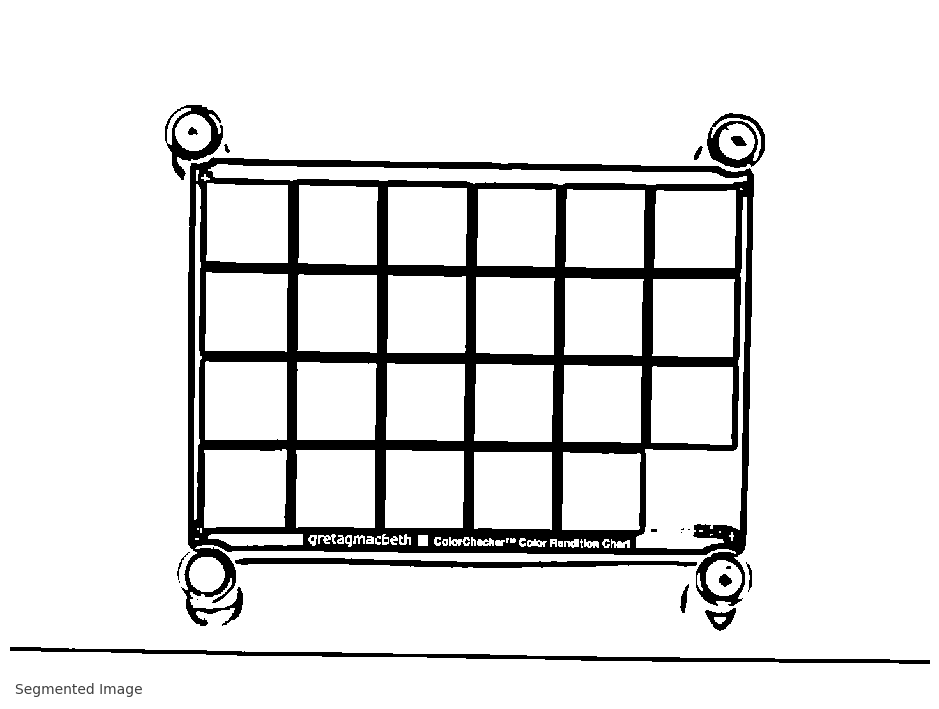

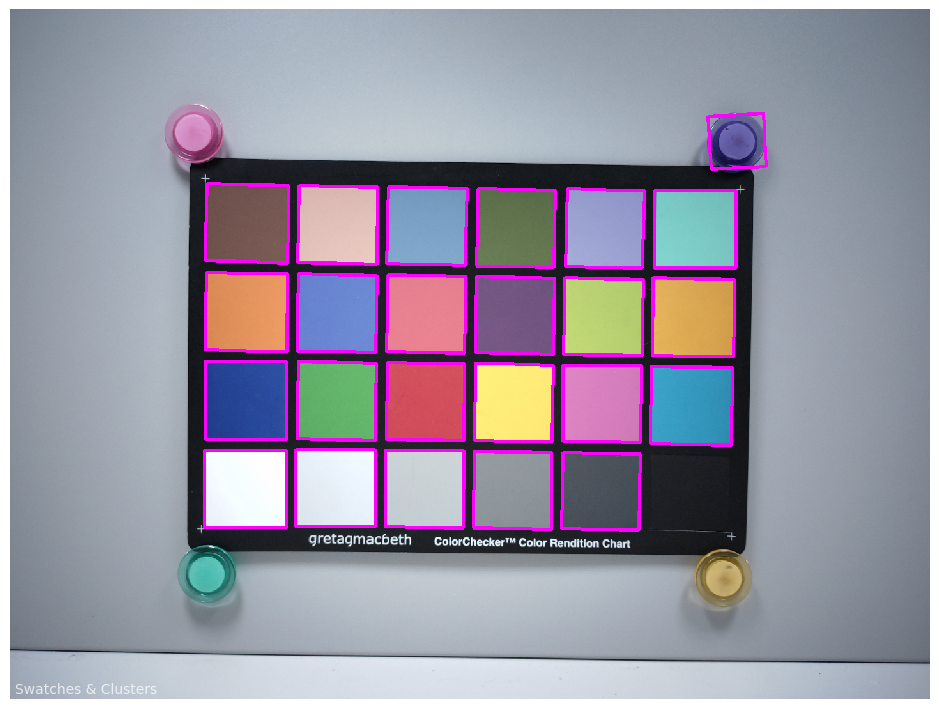

In [10]:
for image in COLOUR_CHECKER_IMAGES:
    colour_checkers, clusters, swatches, segmented_image = (
        colour_checkers_coordinates_segmentation(
            image, additional_data=True).values)
    
    image_a = adjust_image(
        image,
        SETTINGS_SEGMENTATION_COLORCHECKER_CLASSIC['working_width'])

    colour.plotting.plot_image(
        colour.cctf_encoding(segmented_image),
        text_kwargs={
            'text': 'Segmented Image',
            'color': 'black'
    })
    
    cv2.drawContours(image_a, swatches, -1, (1, 0, 1), 3)
    cv2.drawContours(image_a, clusters, -1, (0, 1, 1), 3)

    colour.plotting.plot_image(
        colour.cctf_encoding(image_a),
        text_kwargs={
            'text': 'Swatches & Clusters',
            'color': 'white'
    });